### Parameters Inference Analysis
This notebook is intended for analyzing the process of parameter inference.
It is meant to be used with data generated by an experiment were data was generated from the model and then the parameters of the model were inferred from the generated data.

In [1]:
%matplotlib inline

import os
import sys
import pickle

import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
def get_samps_from_file(base_folder_name, ind, data_file):
    """
    This function reads the samples file from a folder,
    and returns a list [s_0, b, eps_x, epsy, xi_x, xi_y] with the chain for each parameter
    """
    folder_name = base_folder_name + '_' + str(ind)
    
    gen_data_path = os.path.join(folder_name, data_file)
        
    
    try:
        print(gen_data_path)
        with open(gen_data_path, 'rb') as f:
            samples_mu0, samples_b, samples_epsilon, samples_xi = pickle.load(f)    
    except:
        print('problem with folder')
        return None
    
    samples_eps_x = samples_epsilon[:, 0]
    samples_eps_y = samples_epsilon[:, 1]
    samples_xi_x = samples_xi[:, 0]
    samples_xi_y = samples_xi[:, 1]
    
    samples_list = [samples_mu0, samples_b, samples_eps_x, samples_eps_y, samples_xi_x, samples_xi_y]
    
    return samples_list

In [3]:
def autocorr(x):
    """
    This function calculates the autocorrelation of a time series.
    """
    x = np.copy(x)
    x -= np.mean(x)
    result = np.correlate(x, x, mode='full')
    return result[int(result.size/2):] / np.linalg.norm(x)**2

#### Read the samples files

In [4]:
base_folder_name = '../Results/full_model_generated_data_inference/chain'
data_file = 'results/sub_0.p'
num_chains = 3

In [5]:
all_samps = [get_samps_from_file(base_folder_name, i, data_file) for i in range(1, num_chains + 1)]

../Results/full_model_generated_data_inference/chain_1/results/sub_0.p
../Results/full_model_generated_data_inference/chain_2/results/sub_0.p
../Results/full_model_generated_data_inference/chain_3/results/sub_0.p


#### Readh the configurations of the parameters to get the ground truth values

In [6]:
results_path = '../Results/full_model_generated_data_inference/chain_1'
simulation_params_file = os.path.join(results_path, 'input.yml')

config_stream = open(simulation_params_file, 'r')
config = yaml.load(config_stream, Loader=yaml.FullLoader)

eps_config = config['epsilon']
eps_val = np.array(eps_config['value']).astype(float)
alpha_eps = eps_config['alpha']
betta_eps = eps_config['betta']

b_config = config['b']
b_val = b_config['value']
m_b = b_config['m_p']
s_b = b_config['s_p']

mu_config = config['mu_0']
mu_val = mu_config['value']
m_mu0 = mu_config['m_p']
s_mu0 = mu_config['s_p']

xi_config = config['xi']
xi_val = xi_config['value']
alpha_xi = xi_config['alpha']
betta_xi = xi_config['betta']

ground_truth = [mu_val, b_val, eps_val[0], eps_val[1], xi_val[0], xi_val[1]]
params_names = [r'$s_0$', r'$b$', r'$\epsilon_x$', r'$\epsilon_y$', r'$\xi_x$', r'$\xi_y$']

In [7]:
chain_indices = np.arange(num_chains)

#### Plot the chains

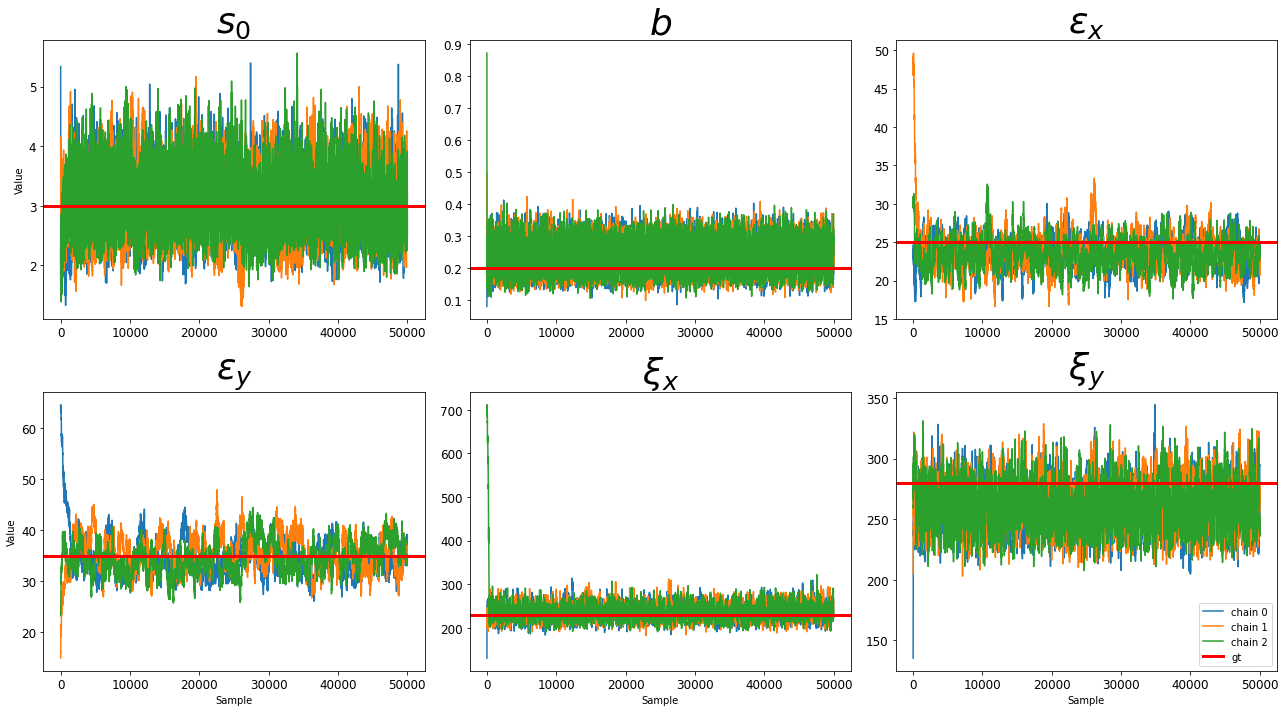

In [12]:
burnin = 0
lim = 50000
thinning = 1

plot_dims = (2, 3)
f, axarr = plt.subplots(*(plot_dims), figsize=(18,10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i, param in enumerate(params_names):
    j, k = np.unravel_index(i, plot_dims)
    ttl = axarr[j][k].set_title(param, fontsize=36, fontweight='bold')
    ttl.set_position([.5, 1.05])
    if j == 1:
        axarr[j][k].set_xlabel('Sample')
    if k == 0:
        axarr[j][k].set_ylabel('Value')
    axarr[j][k].tick_params(labelsize=12)
    for l in chain_indices:
        axarr[j][k].plot(all_samps[l][i][burnin:lim:thinning], label='chain '+ str(l))
    axarr[j][k].axhline(y=ground_truth[i], color='r', lw=3, label='gt')
plt.tight_layout()
plt.legend()
plt.show()

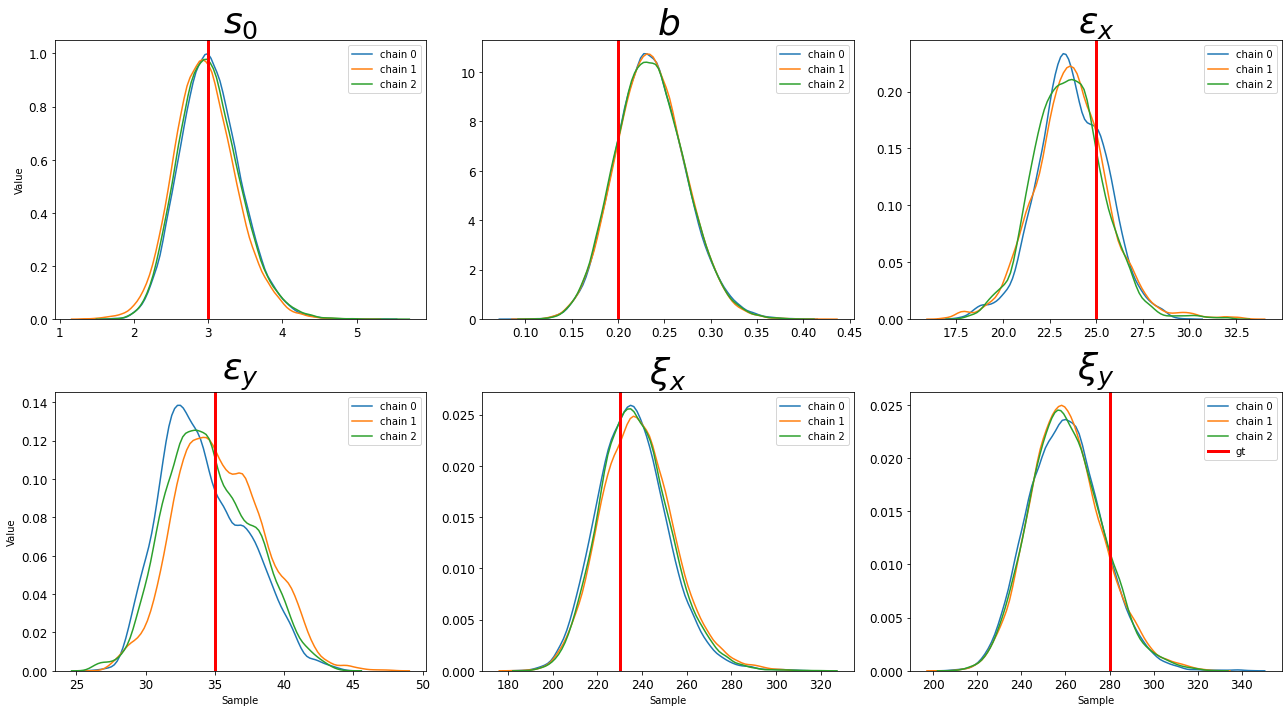

In [14]:
burnin = 5000
lim = 50000
thinning = 1

plot_dims = (2, 3)
f, axarr = plt.subplots(*(plot_dims), figsize=(18,10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i, param in enumerate(params_names):
    j, k = np.unravel_index(i, plot_dims)
    ttl = axarr[j][k].set_title(param, fontsize=36, fontweight='bold')
    ttl.set_position([.5, 1.05])
    if j == 1:
        axarr[j][k].set_xlabel('Sample')
    if k == 0:
        axarr[j][k].set_ylabel('Value')
    axarr[j][k].tick_params(labelsize=12)
    for l in chain_indices:
        sns.distplot(all_samps[l][i][burnin:lim:thinning], hist=False, ax=axarr[j][k], label='chain '+ str(l))
    axarr[j][k].axvline(x=ground_truth[i], color='r', lw=3, label='gt')

plt.tight_layout()
plt.legend()
plt.show()

#### Look at the autocorrelations of the chains

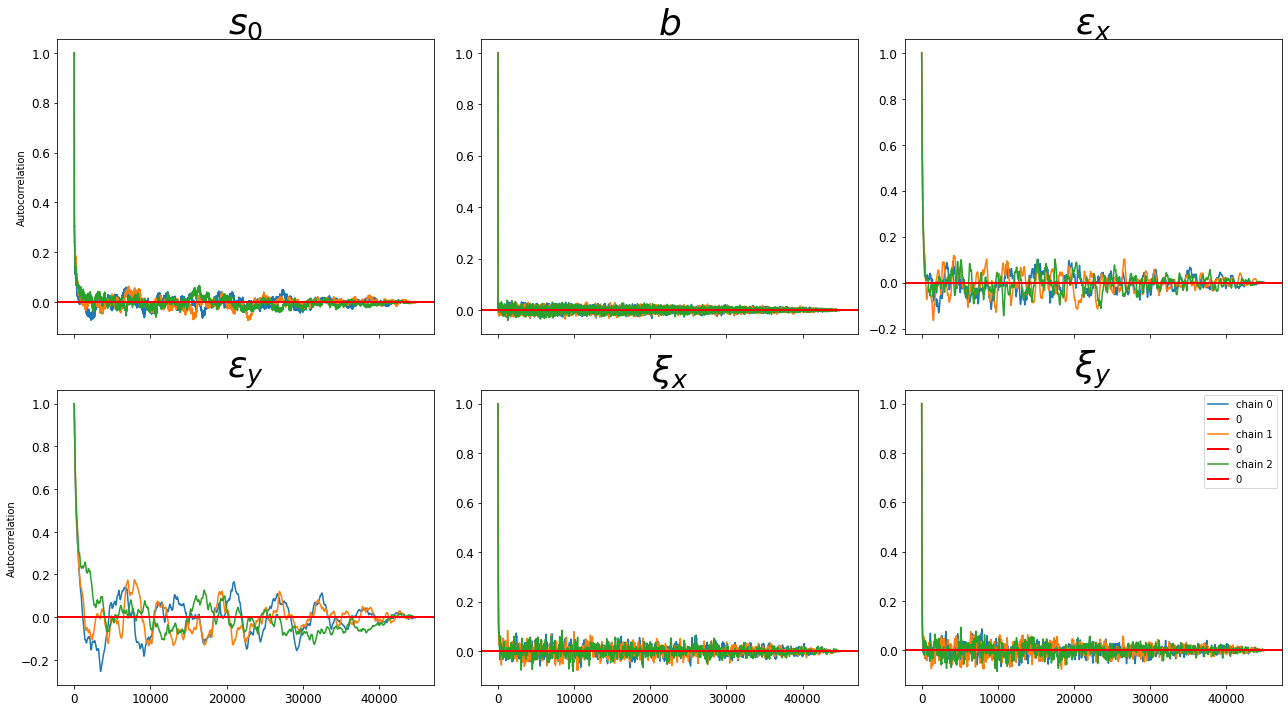

In [18]:
lim = 50000
burnin = 5000
plot_dims = (2, 3)
f, axarr = plt.subplots(*(plot_dims), figsize=(18,10), sharex='col')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i, param in enumerate(params_names):
    j, k = np.unravel_index(i, plot_dims)
    ttl = axarr[j][k].set_title(param, fontsize=36, fontweight='bold')
    ttl.set_position([.5, 1.05])
    if k == 0:
        axarr[j][k].set_ylabel('Autocorrelation')
    axarr[j][k].tick_params(labelsize=12)
    for l in chain_indices:
        auto_corr = autocorr(all_samps[l][i][burnin:lim])
        axarr[j][k].plot(auto_corr, label='chain ' + str(l))
        axarr[j][k].axhline(y=0, color='r', lw=2, label='0')

plt.tight_layout()
plt.legend()
plt.show()